## Modelisation with UNET Mini

In [1]:
import sys  
sys.path.insert(0, './scripts')

# Import librairies, configs, helper functions
from helpers import *

config = base_config

# config["use_saved_model_path"] = "./model_delete.keras"
# config["val_sample_nb"] = 100
# config["train_sample_nb"] = 400
config["width"] = 224
config["height"] = 224
config["mlwflow_experiment_title"] = "UNET VGG16 Resized - Augmented"

n = NotebookProcessor(config)

{
    "width": 224,
    "height": 224,
    "classes": 8,
    "use_augment": true,
    "image_per_augment": 1,
    "max_evals": 1,
    "mlwflow_tracking_uri": "http://127.0.0.1:5000",
    "mlwflow_experiment_title": "UNET VGG16 Resized - Augmented",
    "train_sample_nb": 0,
    "val_sample_nb": 0,
    "use_saved_model_path": "",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip
- Using the full training dataset
- Using the full validation dataset


## Model definition

This is the same model as defined in the Unet VGG16 file excpet that this time, we're forcing the usage of 224x224 pixels to see if the size of the images that was trained on can perform better than the custom one.

## Model creation

In [2]:
def conv_block(input_tensor, num_filters, dropout_rate=0.1):  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_tensor)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    x = Dropout(dropout_rate)(x)  
    x = Conv2D(num_filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)  
    x = BatchNormalization()(x)  # Adding batch normalization  
    return x  
  
def create_model(n_classes, img_width, img_height, img_channels):    
    # Load VGG16 as the encoder with pretrained ImageNet weights  
    base_vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_height, img_width, img_channels))  
      
    # Freeze the layers of VGG16  
    for layer in base_vgg16.layers:  
        layer.trainable = False  
      
    # Encoder - take the outputs of the VGG16 layers to create the contracting path  
    s1 = base_vgg16.get_layer("block1_conv2").output  # 64 filters  
    s2 = base_vgg16.get_layer("block2_conv2").output  # 128 filters  
    s3 = base_vgg16.get_layer("block3_conv3").output  # 256 filters  
    s4 = base_vgg16.get_layer("block4_conv3").output  # 512 filters  
    c5 = base_vgg16.get_layer("block5_conv3").output  # 512 filters, this acts as the bridge  
  
    # Start from bottom and go up, using U-Net's expansive path  
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)    
    u6 = concatenate([u6, s4])    
    c6 = conv_block(u6, 512)   
      
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)    
    u7 = concatenate([u7, s3])    
    c7 = conv_block(u7, 256)    
      
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)    
    u8 = concatenate([u8, s2])    
    c8 = conv_block(u8, 128)    
      
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)    
    u9 = concatenate([u9, s1])    
    c9 = conv_block(u9, 64)    
  
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)    
      
    model = Model(inputs=[base_vgg16.input], outputs=[outputs])  
      
    return model  

## Model Stats

### With augment

2024-02-29 13:00:54.307469: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-29 13:00:54.307489: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-02-29 13:00:54.307493: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-02-29 13:00:54.307525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-29 13:00:54.307541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


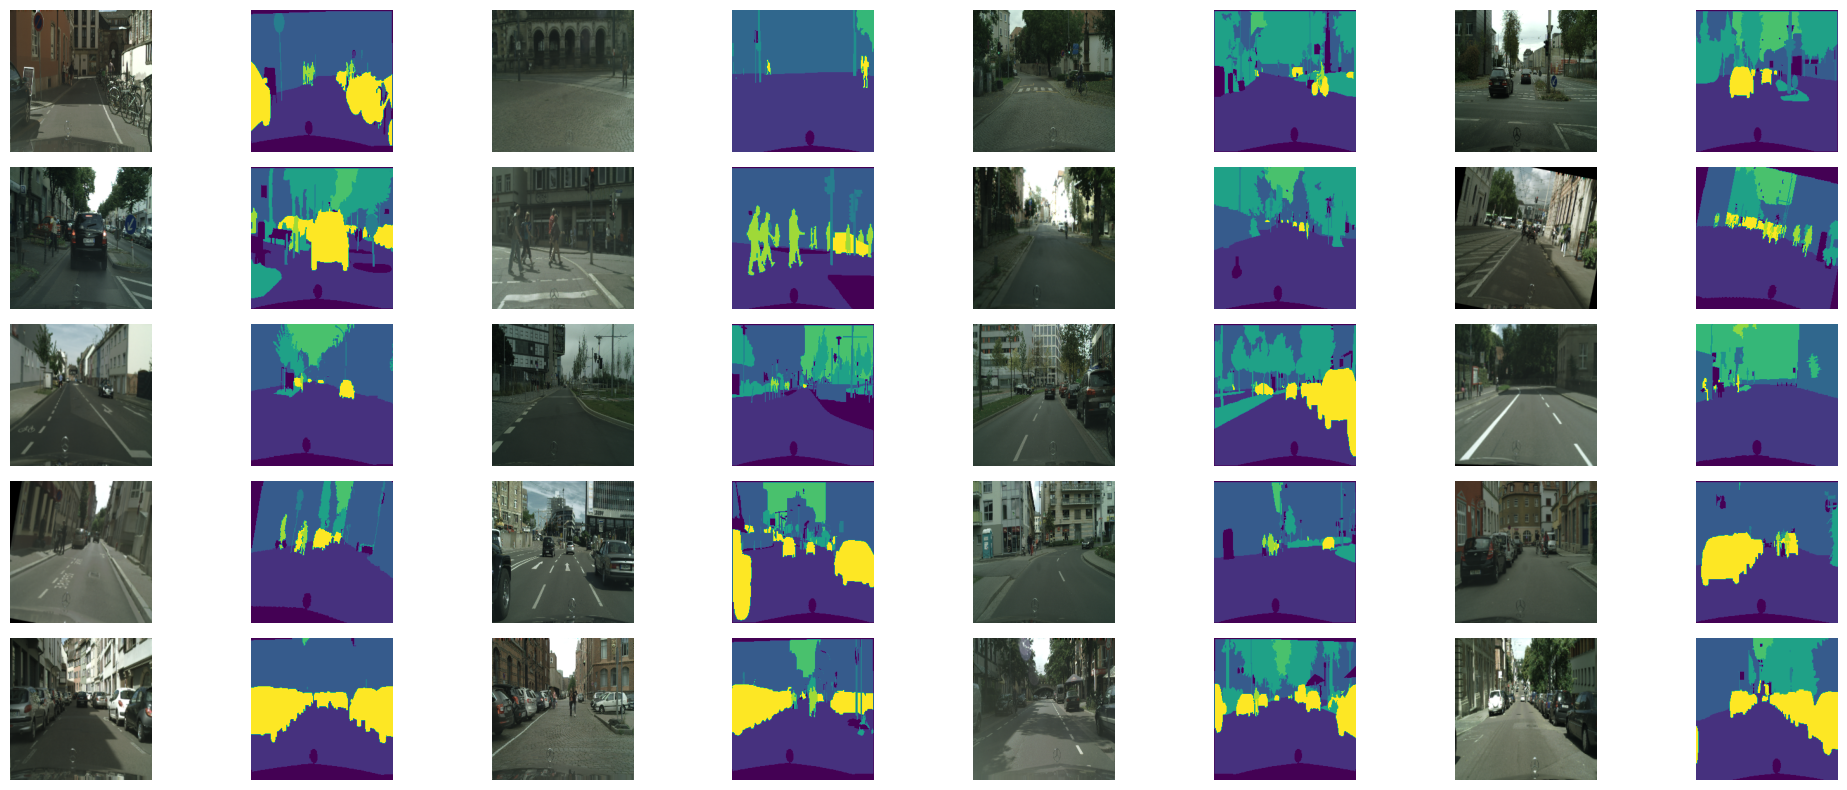

In [3]:
show_data_generator_images_sample(n)

In [4]:
model = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n.set_model(model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [5]:
n.model_fit()

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2024/02/29 13:01:00 INFO mlflow.tracking.fluent: Experiment with name 'UNET VGG16 Resized - Augmented' does not exist. Creating a new experiment.



Epoch 1/12                                           

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2024-02-29 13:01:01.682354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


991/991 [==============================] - 438s 439ms/step - loss: 0.5706 - dice_coef: 0.7364 - iou: 0.5895 - accuracy: 0.8205 - val_loss: 0.6070 - val_dice_coef: 0.7755 - val_iou: 0.6410 - val_accuracy: 0.8164

Epoch 2/12                                           

991/991 [==============================] - 455s 459ms/step - loss: 0.4652 - dice_coef: 0.7795 - iou: 0.6437 - accuracy: 0.8520 - val_loss: 0.5396 - val_dice_coef: 0.7696 - val_iou: 0.6325 - val_accuracy: 0.8257

Epoch 3/12                                           

991/991 [==============================] - 463s 468ms/step - loss: 0.4276 - dice_coef: 0.7959 - iou: 0.6661 - accuracy: 0.8630 - val_loss: 0.5139 - val_dice_coef: 0.7645 - val_iou: 0.6270 - val_accuracy: 0.8356

Epoch 4/12                                           

991/991 [==============================] - 474s 478ms/step - loss: 0.4089 - dice_coef: 0.8042 - iou: 0.6777 - accuracy: 0.8688 - val_loss: 0.5274 - val_dice_coef: 0.7544 - val_iou: 0.6124 - val_accur

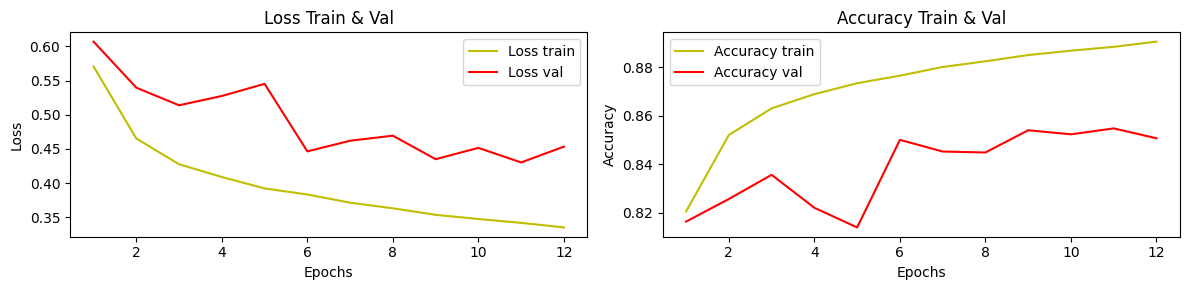

1/1 [==============================] - 0s 414ms/step


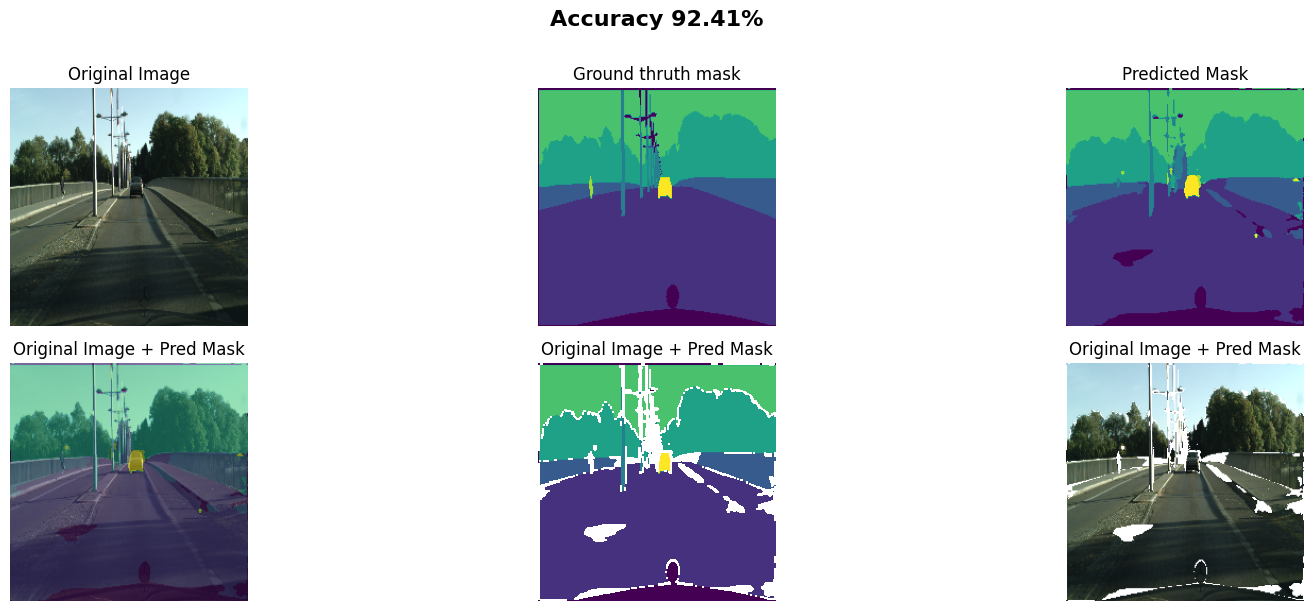

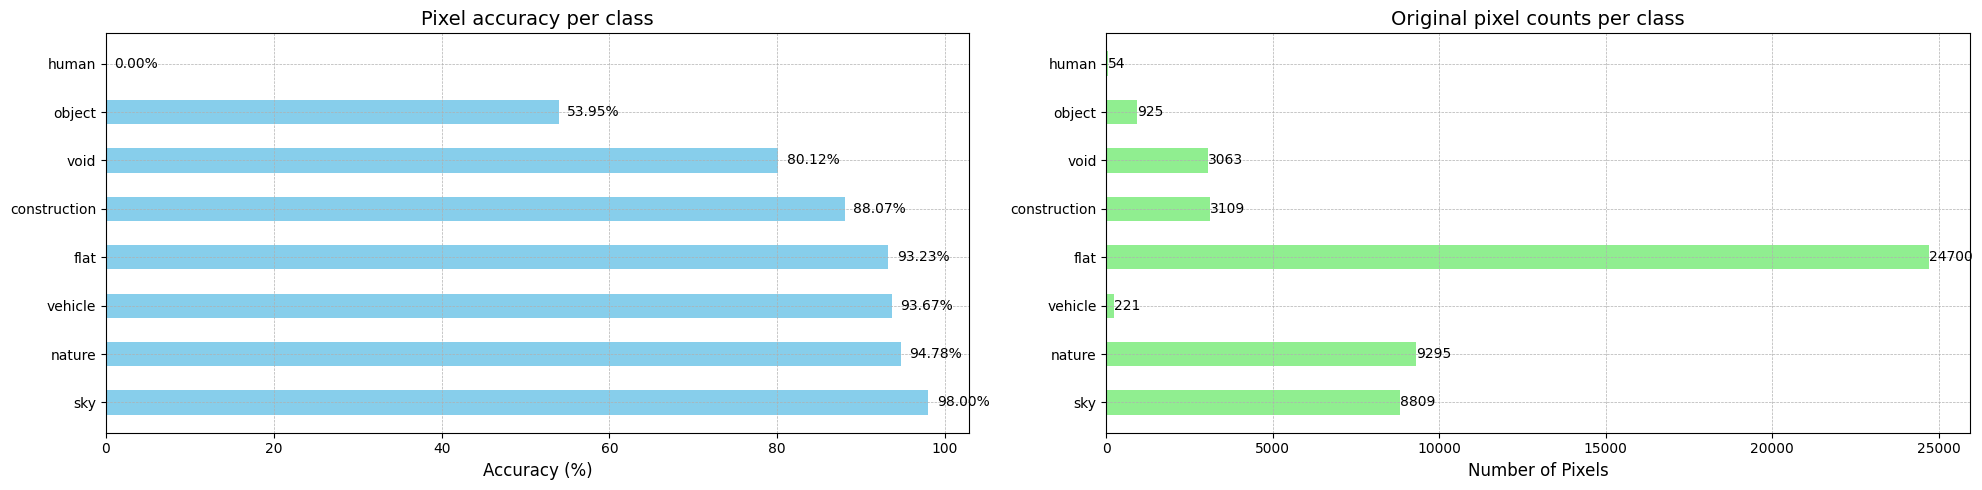

In [6]:
display_loss_and_accuracy(n.model_fit_history)
n.model_predict_with_display_and_accuracy(n.img["val"][0],n.mask["val"][0])

### Without augment

{
    "width": 224,
    "height": 224,
    "classes": 8,
    "use_augment": false,
    "image_per_augment": 1,
    "max_evals": 1,
    "mlwflow_tracking_uri": "http://127.0.0.1:5000",
    "mlwflow_experiment_title": "UNET VGG16 Resized - Not Augmented",
    "train_sample_nb": 0,
    "val_sample_nb": 0,
    "use_saved_model_path": "",
    "gtFine_path": "./data/P8_Cityscapes_gtFine_trainvaltest.zip",
    "leftImg8bit_path": "./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip",
    "data_path": "./data/gtFine"
} 

Dataset already exist, skip downloading: ./data/P8_Cityscapes_gtFine_trainvaltest.zip
Dataset already exist, skip downloading: ./data/P8_Cityscapes_leftImg8bit_trainvaltest.zip
- Using the full training dataset
- Using the full validation dataset


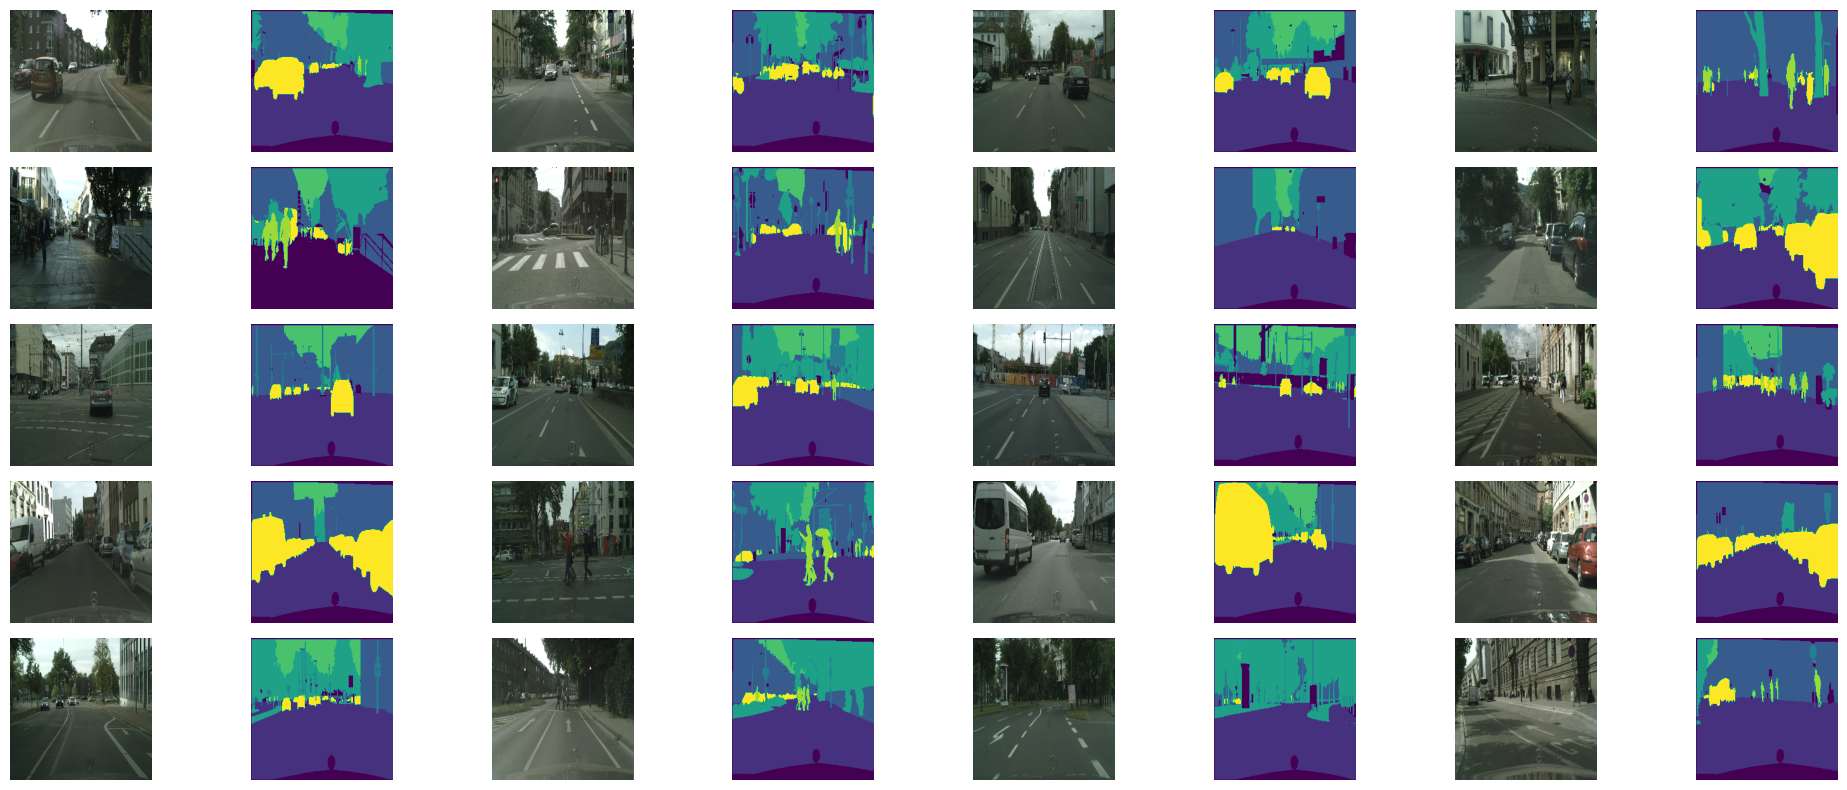

In [7]:
config_not_aug = {
    **config,
    "use_augment": False,
    "mlwflow_experiment_title":"UNET VGG16 Resized - Not Augmented"

}

n_not_aug = NotebookProcessor(config_not_aug)
show_data_generator_images_sample(n_not_aug)

In [8]:
model_not_aug = create_model(n_classes=config["classes"], img_width=config["width"], img_height=config["height"], img_channels=3)
n_not_aug.set_model(model_not_aug)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [9]:
n_not_aug.model_fit()

  0%|          | 0/1 [00:00<?, ?trial/s, best loss=?]

2024/02/29 14:41:32 INFO mlflow.tracking.fluent: Experiment with name 'UNET VGG16 Resized - Not Augmented' does not exist. Creating a new experiment.



Epoch 1/12                                           

991/991 [==============================] - 483s 486ms/step - loss: 0.5771 - dice_coef: 0.7347 - iou: 0.5877 - accuracy: 0.8192 - val_loss: 0.6694 - val_dice_coef: 0.7506 - val_iou: 0.6063 - val_accuracy: 0.8086

Epoch 2/12                                           

991/991 [==============================] - 499s 504ms/step - loss: 0.4663 - dice_coef: 0.7788 - iou: 0.6428 - accuracy: 0.8513 - val_loss: 0.6918 - val_dice_coef: 0.7042 - val_iou: 0.5531 - val_accuracy: 0.7736

Epoch 3/12                                           

991/991 [==============================] - 501s 505ms/step - loss: 0.4315 - dice_coef: 0.7942 - iou: 0.6637 - accuracy: 0.8619 - val_loss: 0.5106 - val_dice_coef: 0.7785 - val_iou: 0.6452 - val_accuracy: 0.8369

Epoch 4/12                                           

991/991 [==============================] - 506s 510ms/step - loss: 0.4071 - dice_coef: 0.8052 - iou: 0.6789 - accuracy: 0.8695 - val_loss: 0.495

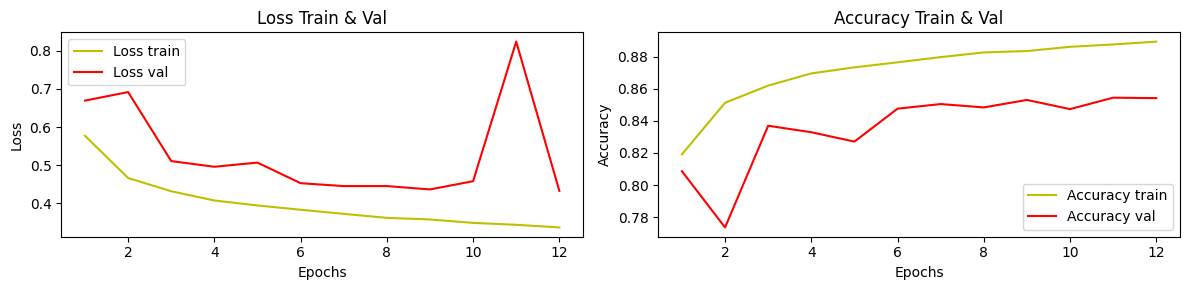

1/1 [==============================] - 1s 502ms/step


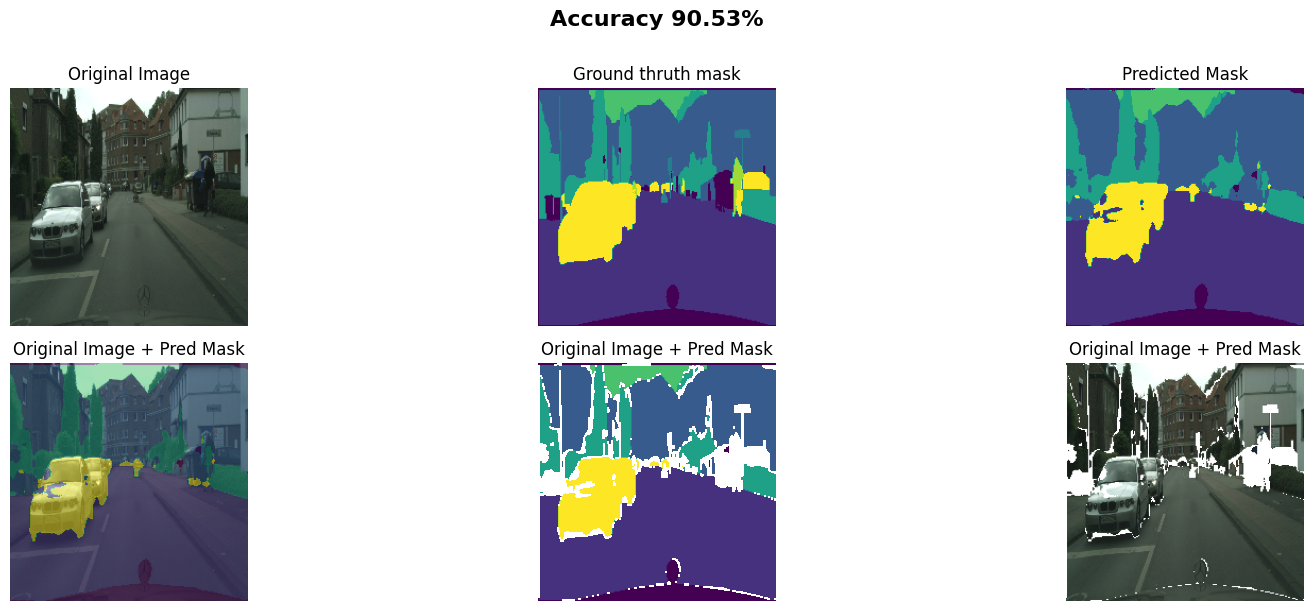

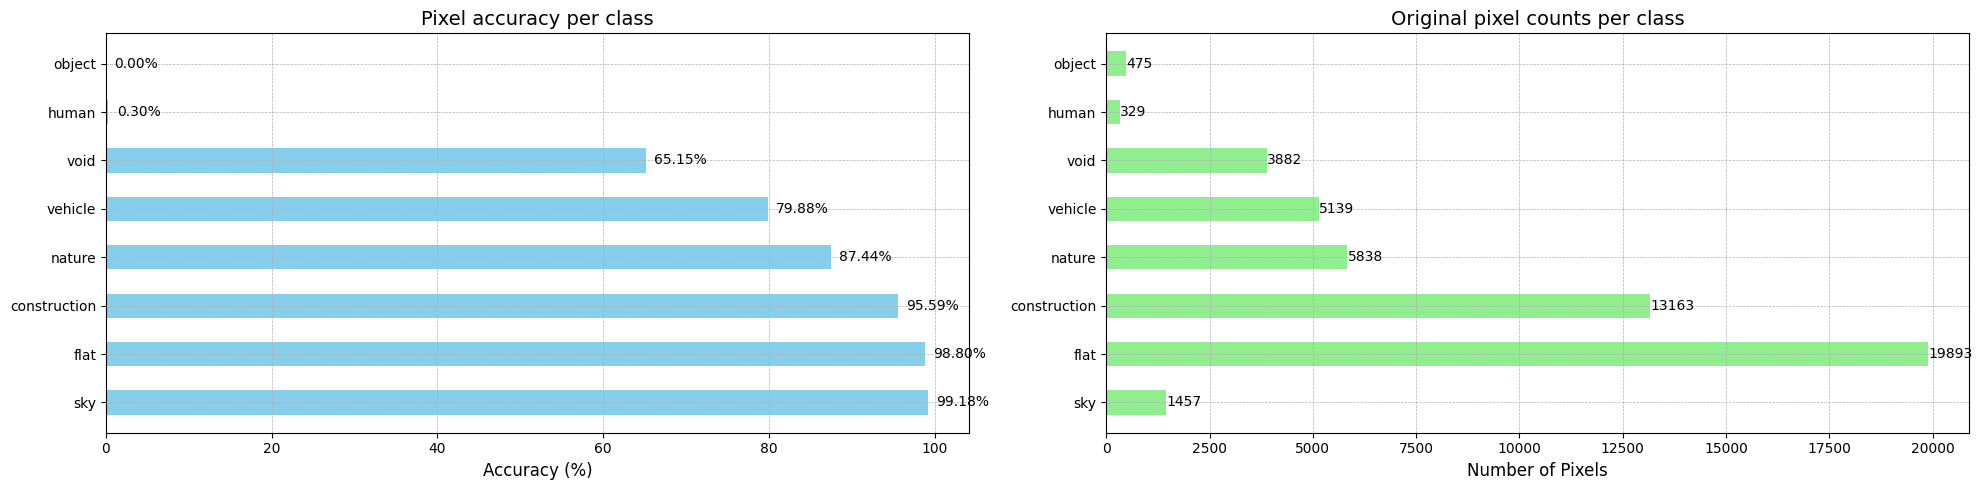

In [10]:
display_loss_and_accuracy(n_not_aug.model_fit_history)
n_not_aug.model_predict_with_display_and_accuracy(n_not_aug.img["test"][1],n_not_aug.mask["test"][1])

### Performance comparaison augmented vs not

50/58 [========================>.....] - ETA: 2s - loss: 0.2883 - dice_coef: 0.8482 - iou: 0.7395 - accuracy: 0.9068

58/58 [==============================] - 18s 299ms/step - loss: 0.3321 - dice_coef: 0.8143 - iou: 0.6909 - accuracy: 0.8943


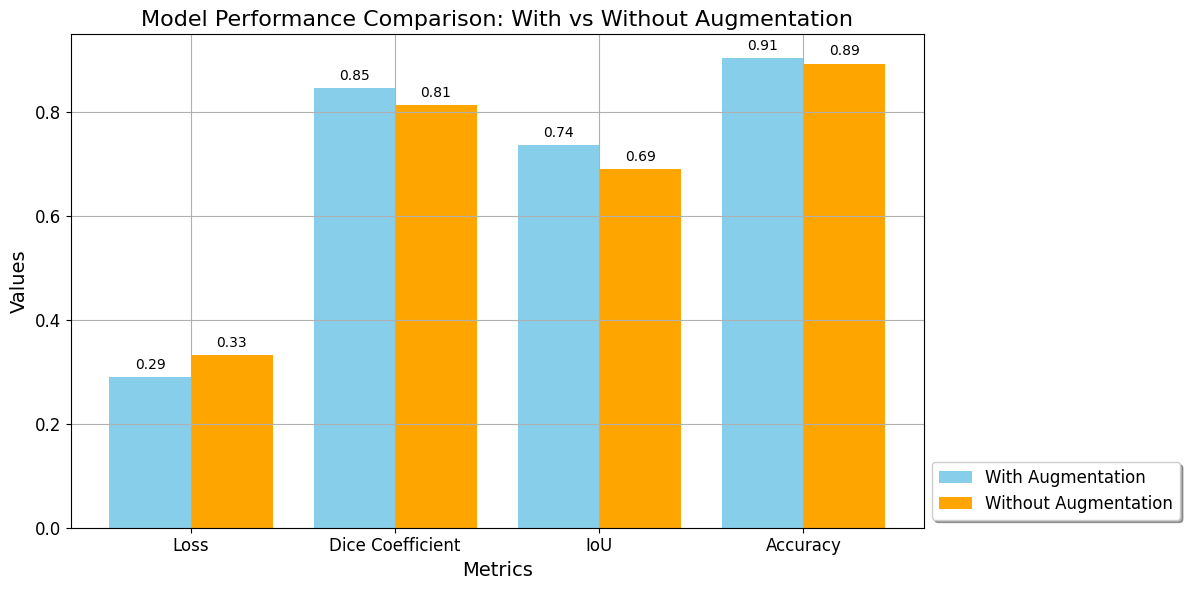

In [11]:
evaluate_with_and_without_aug(n, n_not_aug)

## Model Inference

1/1 [==============================] - 0s 22ms/step


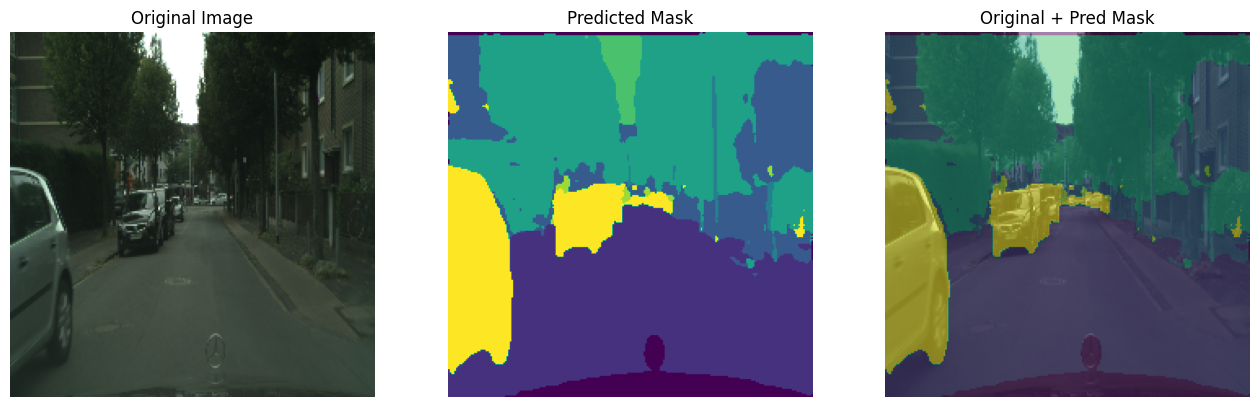

In [12]:
n.model_inference_with_display(n.img["test"][3])

1/1 [==============================] - 0s 55ms/step


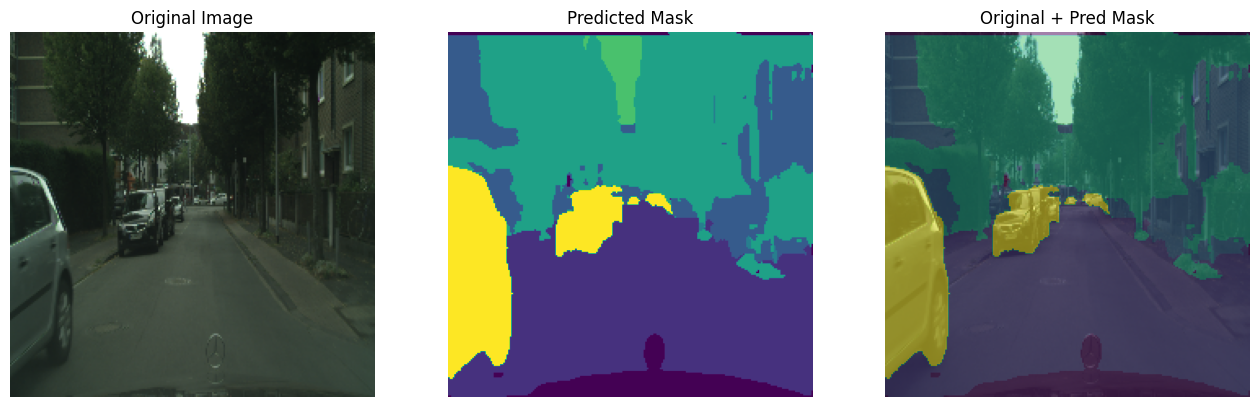

In [13]:
n_not_aug.model_inference_with_display(n_not_aug.img["test"][3])